# Example analysis workflow: TAL1 locus

Goal: We will explore non-coding T-cell acute lymphoblastic leukemia associated
mutations near the *TAL1* locus.

T-cell acute lymphoblastic leukemia (T-ALL) is a cancer of the blood and bone
marrow. A large fraction of T-ALL cases arise due to aberrant upregulation of
the *TAL1* oncogene. In particular, the locus harbors positions in which
non-coding variants can occur that activate *TAL1* gene expression from several
kilobases away.

Key activities:
  1. Visualize the genomic context of variants of interest.
  1. Predict the functional impact of a specific variant on gene expression,
     accessibility, and histone marks.
  1. Systematically compare the predicted effects of known disease-associated
     variants to a set of background variants.

```{tip}
Open this tutorial in Google Colab for interactive viewing.
```

In [1]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

In [3]:
%pip install plotnine 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 68.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [plotnine]3/4 [plotnine]ls]
Note: you may need to restart the kernel to use updated packages.


## Imports

In [4]:
import io
import itertools

from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
from IPython.display import clear_output
import numpy as np
import pandas as pd
import plotnine as gg

In [5]:
from dotenv import load_dotenv
import os
load_dotenv()

ALPHA_GENOME_API_KEY = os.getenv("ALPHA_GENOME_API_KEY")

if not ALPHA_GENOME_API_KEY:
    raise ValueError("ALPHA_GENOME_API_KEY not found in .env file")

dna_model = dna_client.create(ALPHA_GENOME_API_KEY)

We load gene annotations from GENCODE, a public repository of gene information,
using annotations with the highest level of experimental support (Transcript
Support Level '1').

In [6]:
# Load gene annotations (from GENCODE).
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Define an extractor that fetches only MANE_select transcripts per gene.
# Mane select transcripts consists of of one curated transcript per locus.
gtf_transcript = gene_annotation.filter_protein_coding(gtf)
gtf_transcript = gene_annotation.filter_to_mane_select_transcript(
    gtf_transcript
)
transcript_extractor = transcript_utils.TranscriptExtractor(
    gtf_transcript
)

We further define a few utility functions that we'll use throughout the
notebook.

In [7]:
# @title Utilities
def generate_background_variants(
    variant: genome.Variant, max_number: int = 100
) -> pd.DataFrame:
  """Generates a dataframe of background variants for a given variant.

  This is done by creating new sequences of the same length as the alternate
  allele.

  This allows us to test if the specific sequence of the oncogenic variant has a
  greater effect than a random sequence of the same length at the same location.

  Args:
    variant: The variant to generate ism variants for.
    max_number: The maximum number of ism variants to generate.

  Returns:
    A dataframe of variants.
  """
  nucleotides = np.array(list('ACGT'), dtype='<U1')

  def generate_unique_strings(n, max_number, random_seed=42):
    """Generates unique random strings of length n."""
    rng = np.random.default_rng(random_seed)

    if 4**n < max_number:
      raise ValueError(
          'Cannot generate that many unique strings for the given length.'
      )

    generated_strings = set()
    while len(generated_strings) < max_number:
      indices = rng.integers(0, 4, size=n)
      new_string = ''.join(nucleotides[indices])
      if new_string != variant.alternate_bases:
        generated_strings.add(new_string)
    return list(generated_strings)

  permutations = []
  if 4 ** len(variant.alternate_bases) < max_number:
    # Get all
    for p in itertools.product(
        nucleotides, repeat=len(variant.alternate_bases)
    ):
      permutations.append(''.join(p))
  else:
    # Sample some
    permutations = generate_unique_strings(
        len(variant.alternate_bases), max_number
    )
  ism_candidates = pd.DataFrame({
      'ID': ['mut_' + str(variant.position) + '_' + x for x in permutations],
      'CHROM': variant.chromosome,
      'POS': variant.position,
      'REF': variant.reference_bases,
      'ALT': permutations,
      'output': 0.0,
      'original_variant': variant.name,
  })
  return ism_candidates


def oncogenic_and_background_variants(
    input_sequence_length: int, number_of_background_variants: int = 20
) -> pd.DataFrame:
  """Generates a dataframe of all variants for this evaluation."""
  oncogenic_variants = oncogenic_tal1_variants()

  variants = []
  for vcf_row in oncogenic_variants.itertuples():
    variants.append(
        genome.Variant(
            chromosome=str(vcf_row.CHROM),
            position=int(vcf_row.POS),
            reference_bases=vcf_row.REF,
            alternate_bases=vcf_row.ALT,
            name=vcf_row.ID,
        )
    )

  background_variants = pd.concat([
      generate_background_variants(variant, number_of_background_variants)
      for variant in variants
  ])
  all_variants = pd.concat([oncogenic_variants, background_variants])
  return inference_df(all_variants, input_sequence_length=input_sequence_length)


def vcf_row_to_variant(vcf_row: pd.Series) -> genome.Variant:
  """Parse a row of a vcf df into a genome.Variant."""
  variant = genome.Variant(
      chromosome=str(vcf_row.CHROM),
      position=int(vcf_row.POS),
      reference_bases=vcf_row.REF,
      alternate_bases=vcf_row.ALT,
      name=vcf_row.ID,
  )
  return variant


def inference_df(
    qtl_df: pd.DataFrame,
    input_sequence_length: int,
) -> pd.DataFrame:
  """Returns a pd.DataFrame with variants and intervals ready for inference."""
  df = []
  for _, row in qtl_df.iterrows():
    variant = vcf_row_to_variant(row)

    interval = genome.Interval(
        chromosome=row['CHROM'], start=row['POS'], end=row['POS']
    ).resize(input_sequence_length)

    df.append({
        'interval': interval,
        'variant': variant,
        'output': row['output'],
        'variant_id': row['ID'],
        'POS': row['POS'],
        'REF': row['REF'],
        'ALT': row['ALT'],
        'CHROM': row['CHROM'],
    })
  return pd.DataFrame(df)


def coarse_grained_mute_groups(eval_df):
  grp = []
  for row in eval_df.itertuples():
    if row.POS >= 47239290:  # MUTE site.
      if row.ALT_len > 4:
        grp.append('MUTE' + '_other')
      else:
        grp.append('MUTE' + '_' + str(row.ALT_len))
    else:
      grp.append(str(row.POS) + '_' + str(row.ALT_len))

  grp = pd.Series(grp)
  return pd.Categorical(grp, categories=sorted(grp.unique()), ordered=True)

# Assembling variant data

In [8]:
# @title Define variants of interest


def oncogenic_tal1_variants() -> pd.DataFrame:
  """Returns a dataframe of oncogenic T-ALL variants that affect TAL1."""
  variant_data = """
ID	CHROM	POS	REF	ALT	output	Study ID	Study Variant ID
Jurkat	chr1	47239296	C	CCGTTTCCTAACC	1	Mansour_2014
MOLT-3	chr1	47239296	C	ACC	1	Mansour_2014
Patient_1	chr1	47239296	C	AACG	1	Mansour_2014
Patient_2	chr1	47239291	CTAACC	TTTACCGTCTGTTAACGGC	1	Mansour_2014
Patient_3-5	chr1	47239296	C	ACG	1	Mansour_2014
Patient_6	chr1	47239296	C	ACC	1	Mansour_2014
Patient_7	chr1	47239295	AC	TCAAACTGGTAACC	1	Mansour_2014
Patient_8	chr1	47239296	C	AACC	1	Mansour_2014
new 3' enhancer 1	chr1	47212072	T	TGGGTAAACCGTCTGTTCAGCG	1	Smith_2023	UPNT802
new 3' enhancer 2	chr1	47212074	G	GAACGTT	1	Smith_2023	UPNT613
intergenic SNV 1	chr1	47230639	C	T	1	Liu_2020	SJALL043861_D1
intergenic SNV 2	chr1	47230639	C	T	1	Liu_2020	SJALL018373_D1
SJALL040467_D1	chr1	47239296	C	AACC	1	Liu_2020	SJALL040467_D1
PATBGC	chr1	47239296	C	AACC	1	Liu_2017	PATBGC
PATBTX	chr1	47239296	C	ACGGATATAACC	1	Liu_2017	PATBTX
PARJAY	chr1	47239296	C	ACGGAATTTCTAACC	1	Liu_2017	PARJAY
PARSJG	chr1	47239296	C	AACC	1	Liu_2017	PARSJG
PASYAJ	chr1	47239296	C	AACC	1	Liu_2017	PASYAJ
PATRAB	chr1	47239293	TTA	CTAACGG	1	Liu_2017	PATRAB
PAUBXP	chr1	47239296	C	ACC	1	Liu_2017	PAUBXP
PATENL	chr1	47239296	C	AACC	1	Liu_2017	PATENL
PARNXJ	chr1	47239296	C	ACG	1	Liu_2017	PARNXJ
PASXSI	chr1	47239296	C	AACC	1	Liu_2017	PASXSI
PASNEH	chr1	47239296	C	ACC	1	Liu_2017	PASNEH
PAUAFN	chr1	47239296	C	AACC	1	Liu_2017	PAUAFN
PARASZ	chr1	47239296	C	ACC	1	Liu_2017	PARASZ
PARWNW	chr1	47239296	C	ACC	1	Liu_2017	PARWNW
PASFKA	chr1	47239293	TTA	ACCGTTAATCAA	1	Liu_2017	PASFKA
PATEIT	chr1	47239296	C	AC	1	Liu_2017	PATEIT
PASMHF	chr1	47239296	C	AC	1	Liu_2017	PASMHF
PARJNX	chr1	47239296	C	AC	1	Liu_2017	PARJNX
PASYWF	chr1	47239296	C	AC	1	Liu_2017	PASYWF
"""

  return pd.read_table(io.StringIO(variant_data), sep='\t')


oncogenic_tal1_variants().head()

,ID,CHROM,POS,REF,ALT,output,Study ID,Study Variant ID
0,Jurkat,chr1,47239296,C,CCGTTTCCTAACC,1,Mansour_2014,NaN
1,MOLT-3,chr1,47239296,C,ACC,1,Mansour_2014,NaN
2,Patient_1,chr1,47239296,C,AACG,1,Mansour_2014,NaN
3,Patient_2,chr1,47239291,CTAACC,TTTACCGTCTGTTAACGGC,1,Mansour_2014,NaN
4,Patient_3-5,chr1,47239296,C,ACG,1,Mansour_2014,NaN


To get a sense of where these variants lie, we will visualize the variants in
the table above in a ~30kb interval centered around the *TAL1* gene.

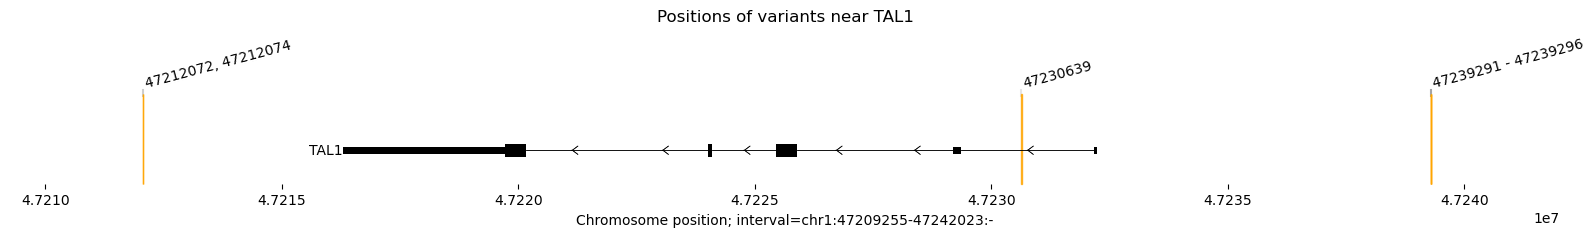

In [9]:
# @title Visualise variant positions.

# Define TAL1 interval.
tal1_interval = genome.Interval(
    chromosome='chr1', start=47209255, end=47242023, strand='-'
)

# Gather unique variant positions and plot labels.
unique_positions = oncogenic_tal1_variants()['POS'].unique()
unique_positions.sort()

# Manually define labels to avoid overplotting.
labels = [
    '47212072, 47212074',
    '',
    '47230639',
    '47239291 - 47239296',
    '',
    '',
    '',
]

# Build plot.
_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(
            transcript_extractor.extract(tal1_interval)
        ),
    ],
    annotations=[
        plot_components.VariantAnnotation(
            [
                genome.Variant(
                    chromosome='chr1',
                    position=x,
                    reference_bases='N',
                    alternate_bases='N',
                )
                for x in unique_positions
            ],
            labels=labels,
            use_default_labels=False,
        )
    ],
    interval=tal1_interval,
    title='Positions of variants near TAL1',
)

From the plot, we can see that the *TAL1* gene is transcribed from right to left
as it is on the (-) strand.

From right to left, we see three positional groups:

1.  a cluster of several 5’ variants upstream of *TAL1*
    ([Mansour et al. 2014](https://pubmed.ncbi.nlm.nih.gov/25394790/),
    [Liu et al. 2017](https://pubmed.ncbi.nlm.nih.gov/28671688/)). This is also
    called the MuTE (“mutation of the TAL1 enhancer”) site.
1.  an intronic variant
    ([Liu et al. 2020](https://pubmed.ncbi.nlm.nih.gov/32632335/)).
1.  a 3’ cluster of two variants downstream of *TAL1*
    ([Smith et al. 2023](https://pubmed.ncbi.nlm.nih.gov/36632736/)).

In the original studies, all three variant groups were shown to converge on a
common mechanism: upregulation of the *TAL1* oncogene.

# Exploring individual variant outcomes

Next, let's plot the predicted effect of one of these variants.

In [10]:
# Define the variant of interest.
variant = vcf_row_to_variant(oncogenic_tal1_variants().iloc[0])
variant

Variant(chromosome='chr1', position=47239296, reference_bases='C', alternate_bases='CCGTTTCCTAACC', name='Jurkat')

In [11]:
# Define the ontology of interest
ontology_terms = ['CL:0001059']

To make predictions relevant to a specific biological context, we provide the
model with an ontology term. Here, we use `CL:0001059'` which corresponds to
["common myeloid progenitor, CD34-positive"](https://www.ebi.ac.uk/ols4/ontologies/cl/classes/http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FCL_0001059).
This is a close match to the tissue-of-origin reported in
[Mansour et al. 2014](https://pubmed.ncbi.nlm.nih.gov/25394790/) ("purified
normal hematopoietic stem cell samples (CD34)"), which used purified
hematopoietic stem cells based on CD34 marker expression.

To make predictions, we'll specify the `interval` (resized to an input sequence
length of 2^20 = 1,048,576 bp). We'll also pass in our `requested_outputs`
field, which indicates to the model to predict three types of outputs: RNA-seq
(a measure of gene expression), DNAse-seq (a measure of DNA accessibility), and
ChIP-Histone (a measure of histone modifications, which can indicate active or
repressed chromatin states).

In [12]:
# Make predictions for sequences containing the REF and ALT alleles.
output = dna_model.predict_variant(
    interval=tal1_interval.resize(2**20),
    variant=variant,
    requested_outputs={
        dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.CHIP_HISTONE,
        dna_client.OutputType.DNASE,
    },
    ontology_terms=ontology_terms,
)

We will use some of the plotting tools provided with the
`alphagenome.visualization` package to build our plot.

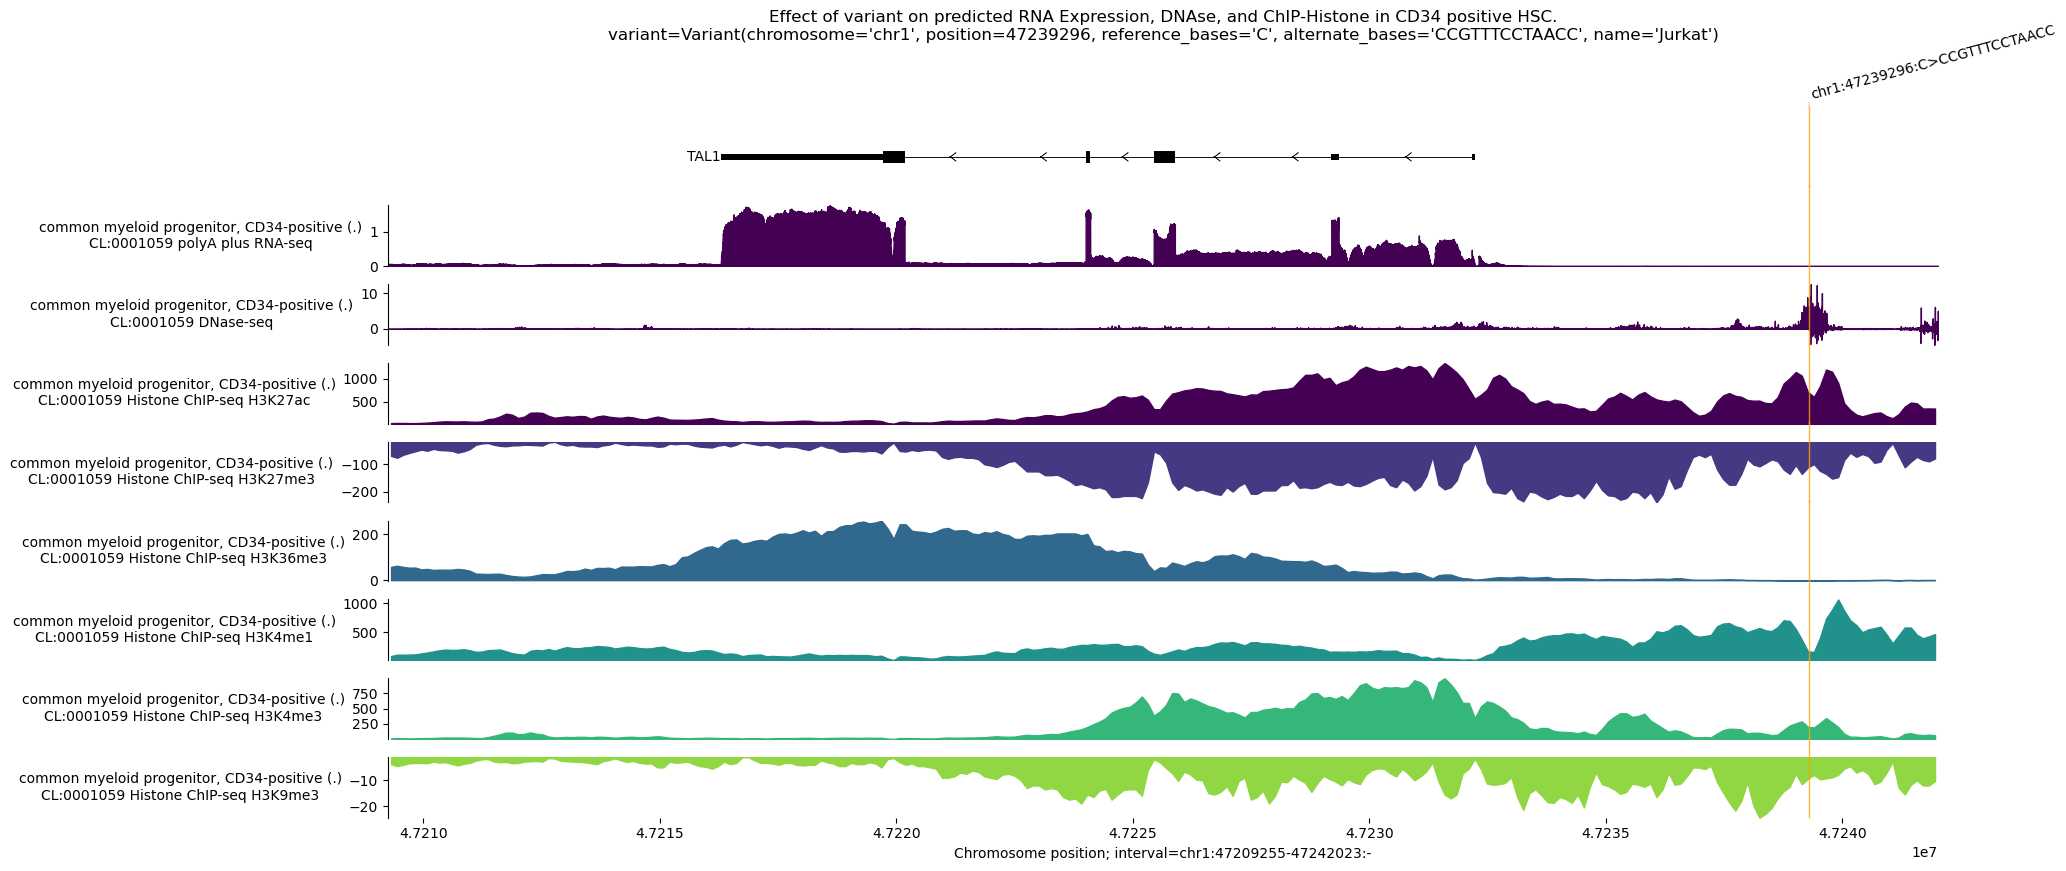

In [13]:
# Build plot.
transcripts = transcript_extractor.extract(tal1_interval)
_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),
        # RNA-seq tracks.
        plot_components.Tracks(
            tdata=output.alternate.rna_seq.filter_to_nonpositive_strand()
            - output.reference.rna_seq.filter_to_nonpositive_strand(),
            ylabel_template='{biosample_name} ({strand})\n{name}',
            filled=True,
        ),
        # DNAse tracks.
        plot_components.Tracks(
            tdata=output.alternate.dnase.filter_to_nonpositive_strand()
            - output.reference.dnase.filter_to_nonpositive_strand(),
            ylabel_template='{biosample_name} ({strand})\n{name}',
            filled=True,
        ),
        # Chip histone.
        plot_components.Tracks(
            tdata=output.alternate.chip_histone.filter_to_nonpositive_strand()
            - output.reference.chip_histone.filter_to_nonpositive_strand(),
            ylabel_template='{biosample_name} ({strand})\n{name}',
            filled=True,
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=tal1_interval,
    title=(
        'Effect of variant on predicted RNA Expression, DNAse, and ChIP-Histone'
        f' in CD34 positive HSC.\n{variant=}'
    ),
)

This plot shows the difference between model predictions for the alternate
sequence (in which in `alternate_bases`, "CCGTTTCCTAACC", have been inserted
into the genome at chromosome 1, position 47239296) and the reference sequence.

Interpreting this plot, we can see that:

-   RNA-seq coverage is above the horizontal, meaning that *TAL1* is increased
    in the presence of the alternate sequence relative to the reference
    sequence.
-   DNAse-seq indicate changing accessibility near the site of the variant, and
    increased accessibility near the transcription start site of *TAL1*.
-   An increase in H3K27ac and H3K4me1 centered directly on the variant's
    location, which mark active enhancers.
-   An increase in H3K4me3 near the transcription start site of *TAL1*, which
    mark active promoters.
-   An increase in H3K36me3 over the gene body, which mark actively transcribed
    genes.
-   A decrease in H3K27me3 and H3K9me3, which are associated with silencing.

Taken together, the model predicts the variant creates a de novo active enhancer
element that activates the TAL1 promoter, leading to robust gene transcription.

# Comparing predicted TAL1 expression change for cancer associated variants, compared to randomly shuffled variants

Next, we will compare *TAL1* expression changes for these cancer associated
mutations, with synthetic, shuffled mutations at those same positions.

To do this, we will:

1.  Generate a set of shuffled background variants.

1.  Use `score_variant` to return a scalar value for each variant corresponding
    to the magnitude of predicted *TAL1* gene expression change in the presence of
    the alternate allele (relevative to the referenece allele).

1.  Plot the predicted *TAL1* expression change, comparing background variants to
    cancer associated ones.

The shuffled background variants will be matched to cancer associated variants,
grouped by position and the length of the `alternate_bases`.

In [14]:
# Preparing variant groups
eval_df = oncogenic_and_background_variants(
    input_sequence_length=2**20, number_of_background_variants=3
)

# Additional annotations and variant groups.
eval_df['ALT_len'] = eval_df['ALT'].str.len()
eval_df['variant_group'] = (
    eval_df['POS'].astype(str) + '_' + eval_df['ALT_len'].astype(str)
)
eval_df['output'] = eval_df['output'].fillna(0) != 0
eval_df['coarse_grained_variant_group'] = coarse_grained_mute_groups(eval_df)

In [15]:
# Score the variants in eval. Takes a minute or so.

scores = dna_model.score_variants(
    intervals=eval_df['interval'].to_list(),
    variants=eval_df['variant'].to_list(),
    variant_scorers=[variant_scorers.RECOMMENDED_VARIANT_SCORERS['RNA_SEQ']],
    max_workers=2,
)
clear_output()

The scores contain values for all genes in the interval, and all RNA-seq tracks
in the model output. We'll filter down to *TAL1* and CD34-positive cells.

In [16]:
# Find the index corresponding to the TAL1 gene.
gene_index = scores[0][0].obs.query('gene_name == "TAL1"').index[0]
# Find the index for our cell type of interest.
cell_type_index = (
    scores[0][0].var.query('ontology_curie == "CL:0001059"').index[0]
)


def get_tal1_score_for_cd34_cells(score_data):
  """Extracts the TAL1 expression score in CD34+ cells from the model output."""
  # Return the specific score.
  return score_data[gene_index, cell_type_index].X[0, 0]


eval_df['tal1_diff_in_cd34'] = [
    get_tal1_score_for_cd34_cells(x[0]) for x in scores
]

Finally, we'll loop through each group and make a plot.

In [17]:
plot_df = eval_df.loc[eval_df.REF != eval_df.ALT]

# Turn variant into a string for easier processing
plot_df['variant'] = plot_df['variant'].astype(str)

plot_df = plot_df.loc[
    :,
    [
        'variant',
        'output',
        'tal1_diff_in_cd34',
        'coarse_grained_variant_group',
    ],
].drop_duplicates()

facet_title_by_group = {
    '47212072_22': 'chr1:47212072\n21 bp ins.',
    '47212074_7': 'chr1:47212072\n21 bp ins.',
    '47230639_1': 'chr1:47230639\nSNV',
    'MUTE_2': 'chr1:47239296\n1 bp ins.',
    'MUTE_3': 'chr1:47239296\n2 bp ins.',
    'MUTE_4': 'chr1:47239296\n3 bp ins.',
    'MUTE_other': 'chr1:47239296\n7-18 bp ins.',
}

plt_dict = {}
plt_list = []
for group in plot_df.coarse_grained_variant_group.unique():
  subplot_df = pd.concat(
      [plot_df.assign(plot_group='density'), plot_df.assign(plot_group='rain')]
  )
  subplot_df = subplot_df[subplot_df.coarse_grained_variant_group == group]
  subplot_df = subplot_df[
      ~((subplot_df.plot_group == 'density') & (subplot_df.output))
  ]

  col_width = np.ptp(subplot_df.tal1_diff_in_cd34) / 200
  subplot_df['col_width'] = subplot_df['output'].map(
      {True: 1.5 * col_width, False: 1.25 * col_width}
  )

  plt_ = (
      gg.ggplot(subplot_df)
      + gg.aes(x='tal1_diff_in_cd34')
      + gg.geom_col(
          gg.aes(
              y=1,
              width='col_width',
              fill='output',
              x='tal1_diff_in_cd34',
              alpha='output',
          ),
          data=subplot_df[subplot_df['plot_group'] == 'rain'],
      )
      + gg.geom_density(
          gg.aes(
              x='tal1_diff_in_cd34',
              fill='output',
          ),
          data=subplot_df[subplot_df['plot_group'] == 'density'],
          color='white',
      )
      + gg.facet_wrap('~output + plot_group', nrow=1, scales='free_x')
      + gg.scale_alpha_manual({True: 1, False: 0.3})
      + gg.scale_fill_manual({True: '#FAA41A', False: 'gray'})
      + gg.labs(title=facet_title_by_group[group])
      + gg.theme_minimal()
      + gg.geom_vline(xintercept=0, linetype='dotted')
      + gg.theme(
          figure_size=(1.2, 3),
          legend_position='none',
          axis_text_x=gg.element_blank(),
          panel_grid_major_x=gg.element_blank(),
          panel_grid_minor_x=gg.element_blank(),
          strip_text=gg.element_blank(),
          axis_title_y=gg.element_blank(),
          axis_title_x=gg.element_blank(),
          plot_title=gg.element_text(size=9),
      )
      + gg.scale_y_reverse()
      + gg.coord_flip()
  )

  plt_dict[group] = plt_
clear_output()

Now we can pick a plot and visualize. Each plot indicates the predicted
expression level of a group of variants. In these plots, the y-axis is the
change in *TAL1* expression in the presence of the alternative allele relative
to the reference allele.

Across the x-axis, there are three visualizations:

1.  A density plot of *TAL1* expression of shuffled variants (gray)
1.  The individual *TAL1* expression data points for the shuffled variants
    underlying the density plot (gray).
1.  The individual *TAL1* expression data points for the cancer associated
    variants in the group (orange).

Here are a few examples:

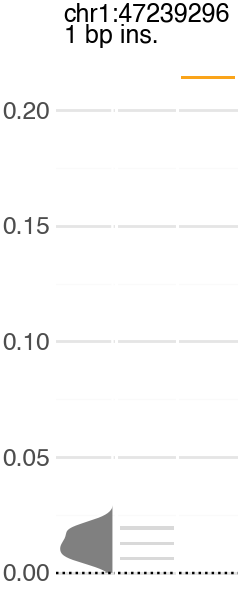

In [18]:
plt_dict['MUTE_2'].show()

/opt/homebrew/Caskroom/miniconda/base/envs/hic-analysis/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals


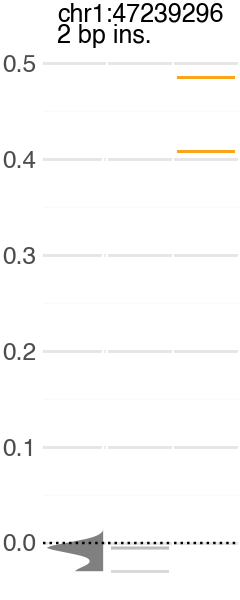

In [19]:
plt_dict['MUTE_3'].show()